In [1]:
from os.path import join
from os import getcwd
from tensorflow import keras
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [4]:
from functions import *
checkpoints_path = getcwd()+'\\checkpoints'

In [5]:
df = pd.read_csv('../../databases/insurance.csv')
x_df = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y_df = df['charges']
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
x_df_edit = x_df.copy()
replace = {
    'sex': {'female':1, 'male':0},
    'smoker':{'yes':1, 'no':0}
}
x_df_edit = x_df_edit.replace(replace)
x_df_edit.head()

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,1,southwest
1,18,0,33.770,1,0,southeast
2,28,0,33.000,3,0,southeast
3,33,0,22.705,0,0,northwest
4,32,0,28.880,0,0,northwest


In [8]:
x_df_encoded = pd.get_dummies(x_df_edit, columns=['region'])
x_df_encoded.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,0,0,0,1
1,18,0,33.770,1,0,0,0,1,0
2,28,0,33.000,3,0,0,0,1,0
3,33,0,22.705,0,0,0,1,0,0
4,32,0,28.880,0,0,0,1,0,0


In [10]:
# Split dataset into 15% test, 85% train_validation 
x, x_test, y, y_test = train_test_split(x_df_encoded, y_df, test_size=0.15)

### Features Polinomiales

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15)

In [13]:
max_poly_order = 10

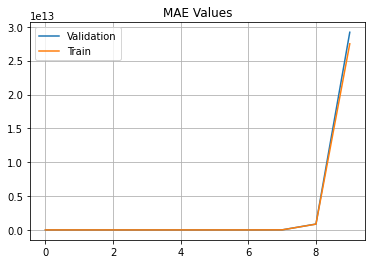

Wall time: 2min 30s


In [20]:
%%time
train_score = [3000]
validation_score = [3000]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_order_{}'.format(i)
    file_dir = join(checkpoints_path, name)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train)
    pol_x_valid = poly.fit_transform(x_valid)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('MAE Values')
plt.legend(loc='best')
plt.grid()
plt.show()

Los mejores modelos son los 3 primeros ordenes, por lo tanto se continuará avanzando sobre ellos

### Normalización de datos

In [31]:
def normalize(dataframe, cols=[], norm_info=None):
    replace = {}
    data = dataframe.copy()
    if norm_info:
        replace=norm_info
    else:
        if len(cols)==0:
            cols = dataframe.keys()
        for col in cols:
            replace[col] = [np.mean(dataframe[col]), np.std(dataframe[col])]
    for key in replace:
        data[key] = (data[key]-replace[key][0])/replace[key][1]
    return data, replace

In [32]:
x_train_n, norm = normalize(x_train, ['age', 'bmi'], None) 
x_valid_n, norm = normalize(x_valid, ['age', 'bmi'], norm)
x_valid_n.describe()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,0.075624,0.532164,-0.085133,0.982456,0.157895,0.233918,0.181287,0.292398,0.292398
std,0.995254,0.500430,0.968684,1.140040,0.365713,0.424564,0.386387,0.456200,0.456200
min,-1.485288,0.000000,-2.241258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.917533,0.000000,-0.829203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.217977,1.000000,-0.153123,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.927671,1.000000,0.541007,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.779304,1.000000,2.825238,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


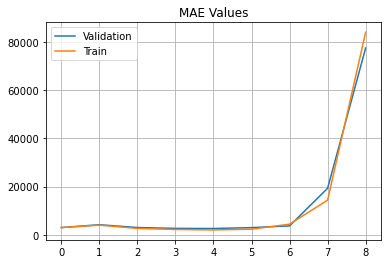

Wall time: 2min 23s


In [40]:
%%time
train_score = [3000]
validation_score = [3000]
all_metrics = {}

for i in range(2,10):
    name = 'poly_order_{}b'.format(i)
    file_dir = join(checkpoints_path, name)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_n)
    pol_x_valid = poly.fit_transform(x_valid_n)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(1), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('MAE Values')
plt.legend(loc='best')
plt.grid()
plt.show()

In [41]:
train_score

[3000,
 4007.061008405894,
 2640.149663512932,
 2206.616255301315,
 2025.7947381132285,
 2328.05393537024,
 4405.870359837336,
 14369.665351286469,
 84016.4688147676]